In [9]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [31]:
RAW_DIR = "/content/drive/MyDrive/mimic-iv-2.2"


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [13]:
for root, dirs, files in os.walk(RAW_DIR):
    print(root)
    for f in files:
        print("  -", f)


/content/drive/MyDrive/mimic-iv-2.2
  - CHANGELOG.txt
  - LICENSE.txt
  - SHA256SUMS.txt
/content/drive/MyDrive/mimic-iv-2.2/hosp
  - hcpcsevents.csv.gz
  - d_hcpcs.csv.gz
  - omr.csv.gz
  - patients.csv.gz
  - d_icd_diagnoses.csv.gz
  - d_icd_procedures.csv.gz
  - microbiologyevents.csv.gz
  - d_labitems.csv.gz
  - drgcodes.csv.gz
  - diagnoses_icd.csv.gz
  - admissions.csv.gz
  - procedures_icd.csv.gz
  - transfers.csv.gz
  - pharmacy.csv.gz
  - prescriptions.csv.gz
  - services.csv.gz
  - provider.csv.gz
  - emar_detail.csv.gz
  - emar.csv.gz
  - poe_detail.csv.gz
  - poe.csv.gz
  - labevents.csv.gz
/content/drive/MyDrive/mimic-iv-2.2/icu
  - caregiver.csv.gz
  - icustays.csv.gz
  - procedureevents.csv.gz
  - inputevents.csv.gz
  - ingredientevents.csv.gz
  - outputevents.csv.gz
  - datetimeevents.csv.gz
  - chartevents.csv.gz
  - d_items.csv.gz


In [14]:
diag = pd.read_csv(f"{RAW_DIR}/hosp/diagnoses_icd.csv.gz")


In [15]:
adm = pd.read_csv(f"{RAW_DIR}/hosp/admissions.csv.gz")


In [16]:
patients = pd.read_csv(f"{RAW_DIR}/hosp/patients.csv.gz")


# ICD Code EDA


##ICD Version Distribution

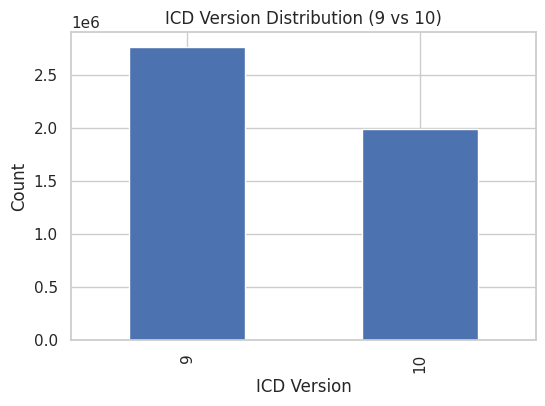

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nicer
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
diag['icd_version'].value_counts().plot(kind='bar')
plt.title("ICD Version Distribution (9 vs 10)")
plt.xlabel("ICD Version")
plt.ylabel("Count")
plt.show()


##ICD Code Length Analysis

In [34]:
diag['code_length'] = diag['icd_code'].astype(str).str.len()

diag['code_length'].describe()


,code_length
count,4.756326e+06
mean,4.565517e+00
std,7.602310e-01
min,3.000000e+00
25%,4.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,7.000000e+00


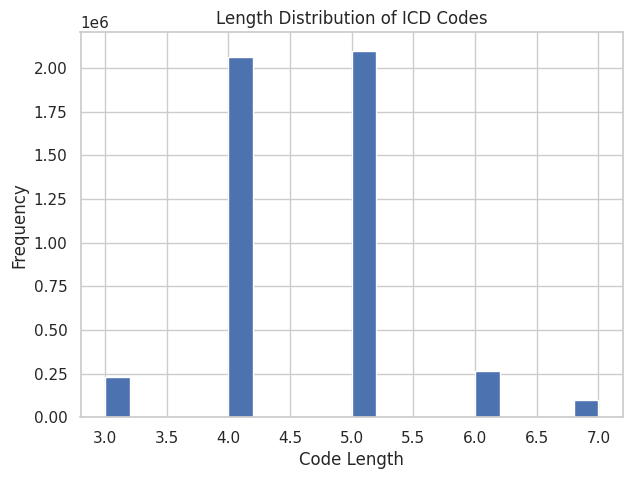

In [35]:
plt.figure(figsize=(7,5))
diag['code_length'].hist(bins=20)
plt.title("Length Distribution of ICD Codes")
plt.xlabel("Code Length")
plt.ylabel("Frequency")
plt.show()


##Compare ICD-9 & ICD-10

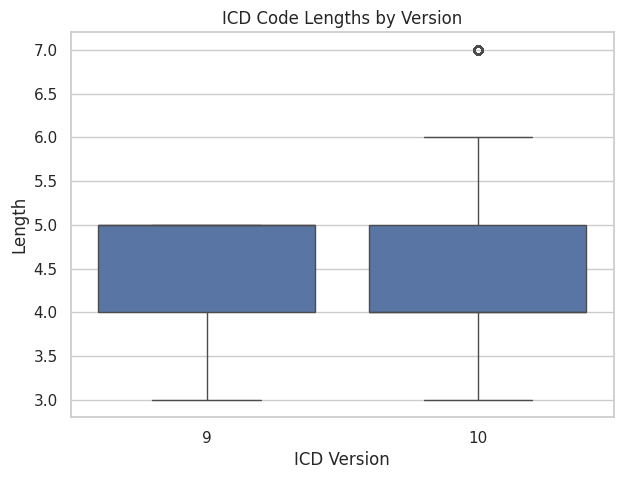

In [36]:
diag.groupby('icd_version')['code_length'].describe()
plt.figure(figsize=(7,5))
sns.boxplot(data=diag, x='icd_version', y='code_length')
plt.title("ICD Code Lengths by Version")
plt.xlabel("ICD Version")
plt.ylabel("Length")
plt.show()


##Prefix Extraction (structure of ICD codes)

##ICD-9 → first 3 digits
##ICD-10 → first letter (chapter)

In [38]:
diag['prefix_3'] = diag['icd_code'].str[:3]
diag['prefix_1'] = diag['icd_code'].str[0]


##Top ICD Prefixes


##ICD-9 (first 3 numbers)

In [39]:
diag[diag['icd_version']==9]['prefix_3'].value_counts().head(15)


,count
prefix_3,
401,101252
272,83708
250,75310
V58,69583
428,65232
V45,64664
276,60442
427,54920
530,52831


##ICD-10 (first letter = chapter)

In [40]:
diag[diag['icd_version']==10]['prefix_1'].value_counts().head(15)


,count
prefix_1,
Z,345623
I,285551
E,236765
R,146087
F,134668
K,127386
N,89066
D,85241
G,80647


##Top 20 ICD Codes

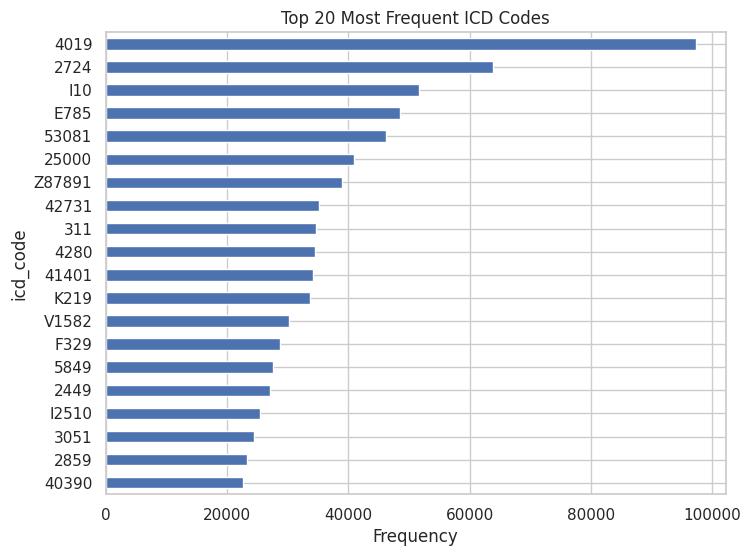

In [41]:
top20 = diag['icd_code'].value_counts().head(20)

plt.figure(figsize=(8,6))
top20.plot(kind='barh')
plt.title("Top 20 Most Frequent ICD Codes")
plt.gca().invert_yaxis()
plt.xlabel("Frequency")
plt.show()


##ICD-10 Chapter Distribution

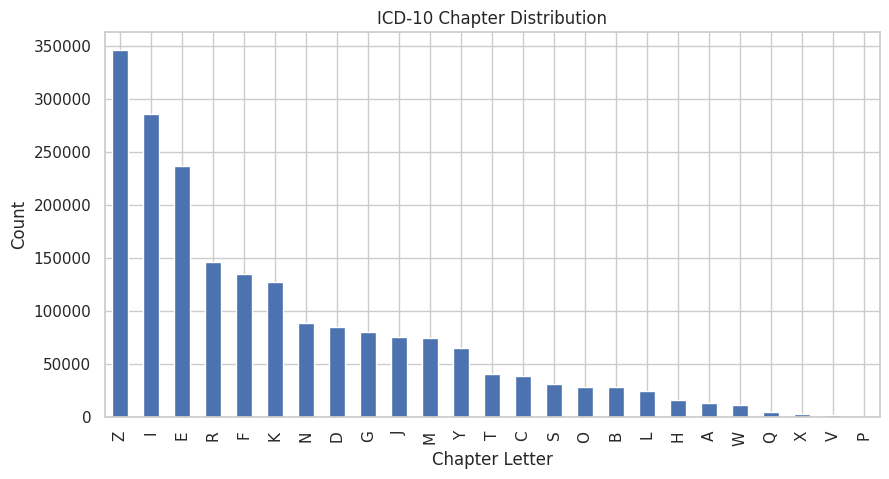

In [42]:
icd10 = diag[diag['icd_version']==10].copy()
icd10['chapter'] = icd10['icd_code'].str[0]

plt.figure(figsize=(10,5))
icd10['chapter'].value_counts().plot(kind='bar')
plt.title("ICD-10 Chapter Distribution")
plt.xlabel("Chapter Letter")
plt.ylabel("Count")
plt.show()


#ICD-9 Major Categories (first digit)

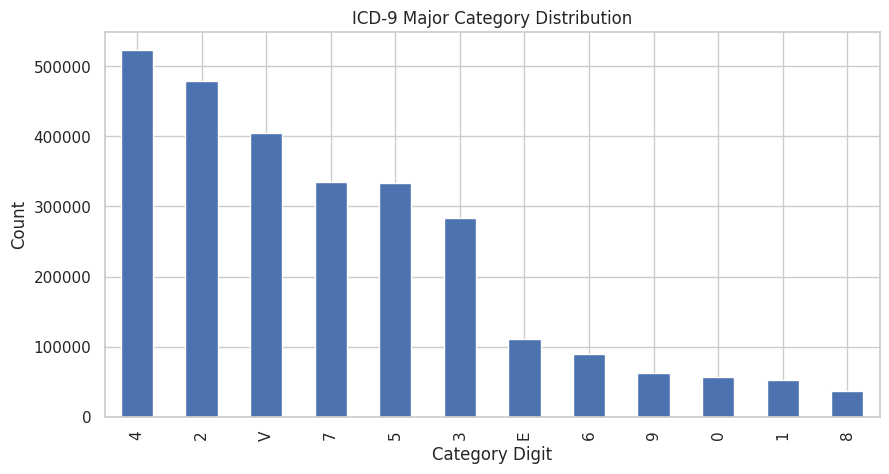

In [43]:
icd9 = diag[diag['icd_version']==9].copy()
icd9['major_category'] = icd9['icd_code'].str[0]

plt.figure(figsize=(10,5))
icd9['major_category'].value_counts().plot(kind='bar')
plt.title("ICD-9 Major Category Distribution")
plt.xlabel("Category Digit")
plt.ylabel("Count")
plt.show()


#Multi-label Co-Occurrence of ICD Codes (Which ICD codes appear together often)

In [44]:
import itertools
from collections import Counter

sample_diag = diag.groupby('hadm_id').head(50).copy()  # avoid heavy compute

co_occur = Counter()

for hadm, group in sample_diag.groupby('hadm_id')['icd_code']:
    codes = list(group)
    for combo in itertools.combinations(sorted(set(codes)), 2):
        co_occur[combo] += 1

co_occur.most_common(15)


[(('2724', '4019'), 36735),
 (('E785', 'I10'), 23835),
 (('25000', '4019'), 22900),
 (('4019', '53081'), 21590),
 (('4019', '41401'), 17972),
 (('E785', 'Z87891'), 17906),
 (('2724', '41401'), 17306),
 (('25000', '2724'), 16941),
 (('2724', '53081'), 16769),
 (('4019', '42731'), 16579),
 (('42731', '4280'), 15046),
 (('I10', 'Z87891'), 15026),
 (('E785', 'I2510'), 14880),
 (('E785', 'K219'), 14833),
 (('2724', '4280'), 14414)]

# Basic dataset overview

In [17]:
print(diag.shape)
diag.head()

print(diag.info())

diag.describe(include='all')


(4756326, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
dtypes: int64(4), object(1)
memory usage: 181.4+ MB
None


,subject_id,hadm_id,seq_num,icd_code,icd_version
count,4.756326e+06,4.756326e+06,4.756326e+06,4756326,4.756326e+06
unique,NaN,NaN,NaN,25809,NaN
top,NaN,NaN,NaN,4019,NaN
freq,NaN,NaN,NaN,97361,NaN
mean,1.499966e+07,2.500011e+07,8.421183e+00,NaN,9.418274e+00
std,2.878717e+06,2.888907e+06,6.555925e+00,NaN,4.932757e-01
min,1.000003e+07,2.000002e+07,1.000000e+00,NaN,9.000000e+00
25%,1.249952e+07,2.249706e+07,3.000000e+00,NaN,9.000000e+00
50%,1.499724e+07,2.500188e+07,7.000000e+00,NaN,9.000000e+00
75%,1.749634e+07,2.750289e+07,1.200000e+01,NaN,1.000000e+01


# Check missing values

In [18]:
diag.isnull().mean().sort_values(ascending=False).head(20)


,0
subject_id,0.0
hadm_id,0.0
seq_num,0.0
icd_code,0.0
icd_version,0.0


# Count unique ICD codes

In [19]:
diag["icd_code"].nunique()


25809

# Distribution of ICD code versions

In [20]:
diag["icd_version"].value_counts()


,count
icd_version,
9,2766877
10,1989449


##Top ICD codes

In [21]:
diag["icd_code"].value_counts().head(20)


,count
icd_code,
4019,97361
2724,63875
I10,51706
E785,48581
53081,46238
25000,41029
Z87891,38893
42731,35180
311,34632


# Explore patient demographics

In [22]:
patients.describe(include='all')


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
count,2.997120e+05,299712,299712.000000,299712.000000,299712,29076
unique,NaN,2,NaN,NaN,5,19041
top,NaN,F,NaN,NaN,2008 - 2010,2151-07-30
freq,NaN,158553,NaN,NaN,96695,7
mean,1.500885e+07,NaN,48.539888,2151.124056,NaN,NaN
std,2.885019e+06,NaN,20.895650,23.464598,NaN,NaN
min,1.000003e+07,NaN,18.000000,2110.000000,NaN,NaN
25%,1.250796e+07,NaN,29.000000,2131.000000,NaN,NaN
50%,1.501416e+07,NaN,48.000000,2151.000000,NaN,NaN
75%,1.750489e+07,NaN,65.000000,2171.000000,NaN,NaN


##Age distribution

Text(0, 0.5, 'Count')

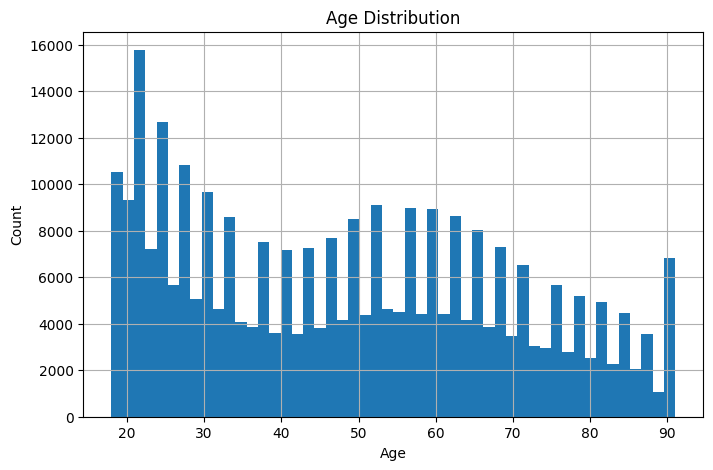

In [23]:
patients['anchor_age'].hist(bins=50, figsize=(8,5))
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")


##Gender counts

Text(0, 0.5, 'Count')

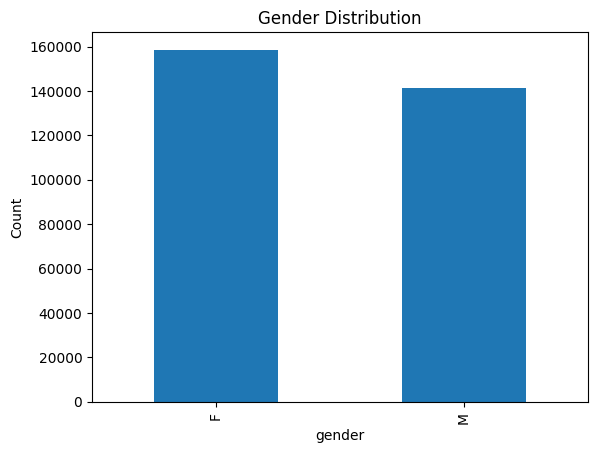

In [24]:
patients['gender'].value_counts().plot(kind='bar')
plt.title("Gender Distribution")
plt.ylabel("Count")


#Explore admissions

##Admission locations

In [25]:
adm['admission_location'].value_counts().head(10)


,count
admission_location,
EMERGENCY ROOM,232595
PHYSICIAN REFERRAL,114963
TRANSFER FROM HOSPITAL,35974
WALK-IN/SELF REFERRAL,15816
CLINIC REFERRAL,10008
PROCEDURE SITE,7804
PACU,5479
INTERNAL TRANSFER TO OR FROM PSYCH,4205
TRANSFER FROM SKILLED NURSING FACILITY,3843


##Length of stay

Text(0, 0.5, 'Count')

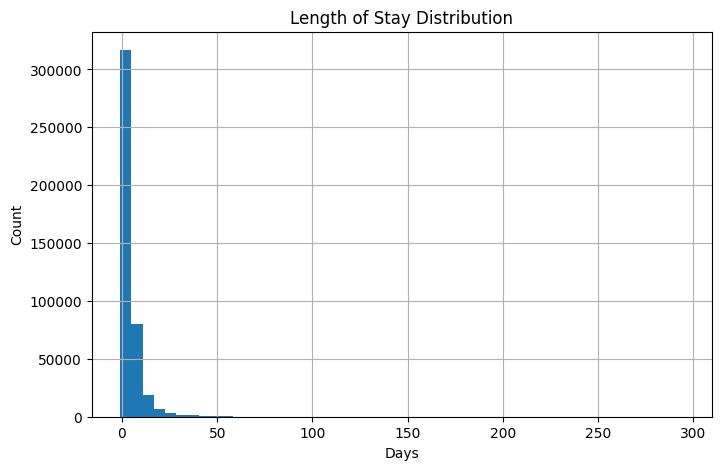

In [26]:
adm['los'] = (pd.to_datetime(adm['dischtime']) - pd.to_datetime(adm['admittime'])).dt.days

adm['los'].hist(bins=50, figsize=(8,5))
plt.title("Length of Stay Distribution")
plt.xlabel("Days")
plt.ylabel("Count")


# Joining tables for richer EDA


##link diagnoses → admissions → patients:

In [27]:
merged = diag.merge(adm, on=['subject_id', 'hadm_id'], how='left')
merged = merged.merge(patients, on=['subject_id'], how='left')


# Analyze diagnoses by patient demographics

##ICD codes by gender

In [28]:
merged.groupby('gender')['icd_code'].nunique()


,icd_code
gender,
F,21024
M,20364


##Most frequent ICD codes by age groups

In [29]:
merged['age_group'] = pd.cut(
    merged['anchor_age'],
    bins=[0, 18, 40, 60, 80, 120],
    labels=['0-18', '18-40', '40-60', '60-80', '80+']
)

merged.groupby('age_group')['icd_code'].count()


/tmp/ipython-input-2632238001.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.groupby('age_group')['icd_code'].count()


,icd_code
age_group,
0-18,8062
18-40,652276
40-60,1452466
60-80,1910754
80+,732768


#Saving EDA summary outputs

In [ ]:
merged.describe(include='all').to_csv("mimiciv_summary.csv")
